# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
import torch
# import tensorflow as tf

In [3]:
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
print("CUDA version:", torch.version.cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# gpus = tf.config.list_physical_devices('GPU')
# print(f"Num GPUs: {len(gpus)}")

CUDA available: True
GPU name: NVIDIA GeForce RTX 3050 6GB Laptop GPU
CUDA version: 12.1
Using device: cuda


In [4]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FAUZAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\FAUZAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FAUZAN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Load

In [5]:
file_path = 'train.csv'

df = pd.read_csv(file_path)
df.head()

,Category,Text
0,Accountant,education omba executive leadership university...
1,Accountant,howard gerrard accountant deyjobcom birmingham...
2,Accountant,kevin frank senior accountant inforesumekraftc...
3,Accountant,place birth nationality olivia ogilvy accounta...
4,Accountant,stephen greet cpa senior accountant 9 year exp...


In [6]:
print(df['Text'].iloc[0])

education omba executive leadership university texas 20162018 bachelor science accounting richland college 20052008 training certifications certified management accountant cma certified financial modeling valuation analyst compliance antimoney laundering 092016 american institute banking certified public account cpa lean six sigma green belt certified trade products financial regulations 082016 american institute banking achievements speaker bringing leader within 082019 successfully presented empowering speech leadership 500 participants speaker dallas convention cpas 032019 successfully delivered seminar 3k cpas convention guests teaching experience online teacher udemy 2017 taught online accounting nonaccountant course udemy similar online teaching platforms developed effective teaching modules materials curriculum target students took feedbacks students assist improving teaching methodology materials professional memberships affiliations american society executives 2018 present tec

# Data Understanding w Visual

In [7]:
df_explore = df.copy()

In [8]:
for i in range (5):
  idx = np.random.randint(0, len(df_explore))
  print(f"text index {idx} ({df_explore['Category'].iloc[idx]}): {df_explore['Text'].iloc[idx]}")

text index 10418 (Human Resources): jessica claire 100 montgomery st 10th floor 555 4321000 resumesampleexamplecom summary business operations senior leader offering 25 year history leading strategic tactical business human resource initiatives proven expertise largescale business transformation change management consistently exceed company objectives offering effective communication team building coaching skills commitment fostering company vision building professional culture rooted trust mutual respect complex problemsolving mastery strategic business planning vice presidentsenior leader human resources 012021 current skills executive leadership policy development experience gainesville health care center gainesville fl translate business objectives strategic hr function collaboration management team craft companys vision culture mission serve trusted advisor business partner functioning expert people organizational issues developing human resource programs initiatives practical bus

data hasil ekstraksi dengan cv/resume yang digunakan berbahasa inggris

In [9]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13389 entries, 0 to 13388
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  13389 non-null  object
 1   Text      13389 non-null  object
dtypes: object(2)
memory usage: 209.3+ KB


In [10]:
df_explore.isnull().sum()

Category    0
Text        0
dtype: int64

In [11]:
df_explore.nunique()

Category       43
Text        12085
dtype: int64

- Terdapat 43 kategori/label  
- Di sini nunique pada teks lebih sedikit dibanding pada informasi yang didapat dari df.info(). tandanya terdapat nilai duplikat

In [12]:
df_explore.duplicated().sum()

np.int64(1114)

In [13]:
df_explore["Category"].unique()

array(['Accountant', 'Advocate', 'Agriculture', 'Apparel', 'Architecture',
       'Arts', 'Automobile', 'Aviation', 'Banking', 'Blockchain', 'BPO',
       'Building and Construction', 'Business Analyst', 'Civil Engineer',
       'Consultant', 'Data Science', 'Database', 'Designing', 'DevOps',
       'Digital Media', 'DotNet Developer', 'Education',
       'Electrical Engineering', 'ETL Developer', 'Finance',
       'Food and Beverages', 'Health and Fitness', 'Human Resources',
       'Information Technology', 'Java Developer', 'Management',
       'Mechanical Engineer', 'Network Security Engineer',
       'Operations Manager', 'PMO', 'Public Relations',
       'Python Developer', 'React Developer', 'Sales', 'SAP Developer',
       'SQL Developer', 'Testing', 'Web Designing'], dtype=object)

In [14]:
len(df_explore["Category"].unique())

43

terdapat 43 kategori unik

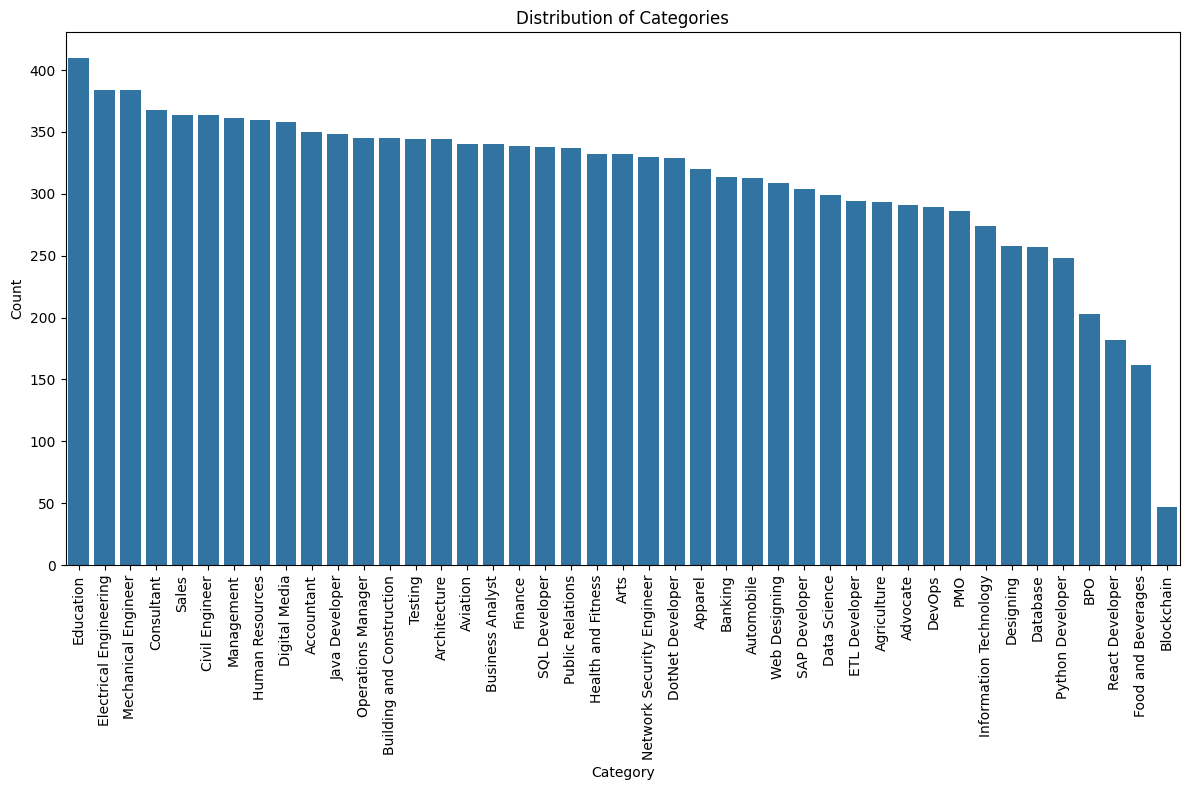

In [14]:
category_counts = df_explore['Category'].value_counts()

plt.figure(figsize=(12, 8))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Categories')
plt.tight_layout()
plt.show()

In [15]:
col = "Text"

df_explore['word_count'] = df_explore[col].apply(lambda x: len(str(x).split()))
df_explore['char_count'] = df_explore[col].apply(lambda x: len(str(x)))
terpendak = df_explore.loc[df_explore['word_count'].idxmin()][col]
longest  = df_explore.loc[df_explore['word_count'].idxmax()][col]

print("Rata-rata jumlah kata :", df_explore['word_count'].mean())
print("Resume terpendek:", terpendak)
print("Resume terpanjang:", longest)

Rata-rata jumlah kata : 474.9489879752035
Resume terpendek: agriculture natural resources perfect resume
Resume terpanjang: jessica claire 100 montgomery st 10th floor 555 4321000 resumesampleexamplecom summary industrious founder experience generating investor funding developing customer bases handling diverse leadership functions growthoriented leader dedicated developing companies within proponent forming highqujessicaty successful cohesive teams skills new business development strategic business planning team building leadership planning coordination experience financial leadership executive leadership industry partnership development 102018 current founder executive director hca asheboro nc contribute university initiatives enhance morgans status doctoral research university prepare r1 designation oversee new academic programs program revisions collaborate across departments schools colleges advocate development international programs monitor course offerings course program enroll

In [16]:
col = "Text"

stop_words = set(stopwords.words('english'))

tokens = [word.lower() for Text in df[col] for word in word_tokenize(str(Text))]
tokens_nostop = [w for w in tokens if w.isalpha() and w not in stop_words]

word_freq = Counter(tokens_nostop).most_common(20)
print("Top 20 kata:", word_freq)

Top 20 kata: [('management', 42463), ('data', 38991), ('experience', 33096), ('business', 31653), ('skills', 31057), ('team', 29058), ('customer', 27312), ('using', 27183), ('project', 26660), ('development', 26581), ('new', 25602), ('work', 23545), ('design', 21791), ('service', 20006), ('sales', 19834), ('state', 18393), ('support', 18222), ('developed', 17916), ('systems', 17510), ('education', 17386)]


In [17]:
unique_words = set(tokens_nostop)
vocab_size = len(unique_words)
total_words = len(tokens_nostop)
print("Vocabulary size:", vocab_size)
print("Rasio unik/total:", vocab_size / total_words)

Vocabulary size: 108603
Rasio unik/total: 0.01779366893843708


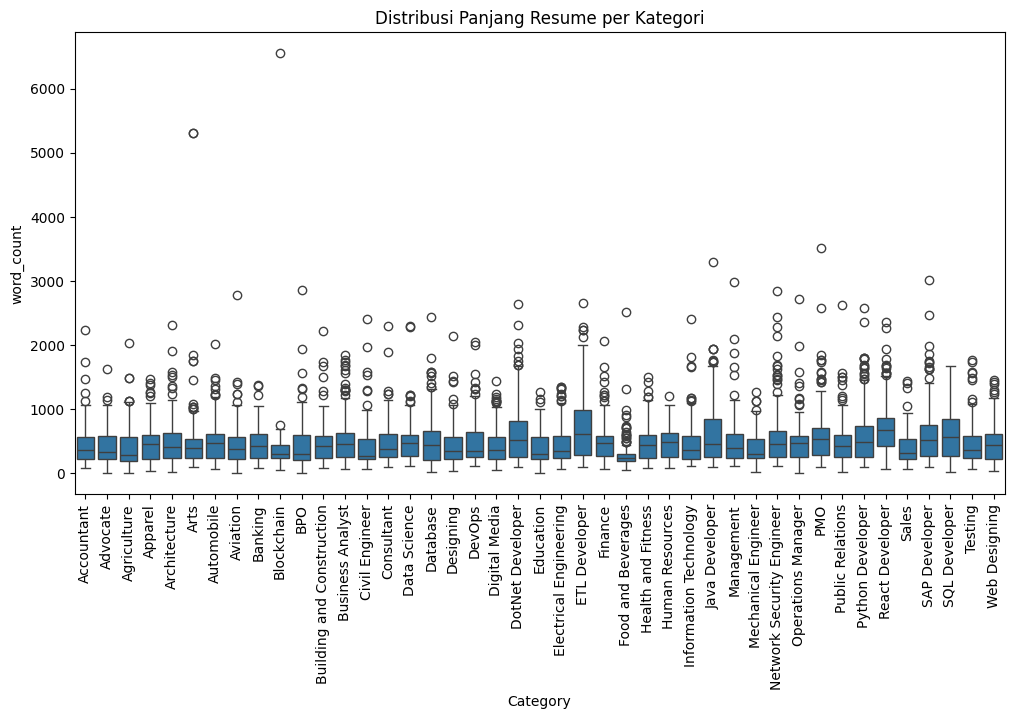

In [18]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_explore, x='Category', y='word_count')
plt.xticks(rotation=90)
plt.title("Distribusi Panjang Resume per Kategori")
plt.show()

In [19]:
category_counts = df_explore['Category'].value_counts()
imbalance_ratio = category_counts.max() / category_counts.min()
print("Rasio ketidakseimbangan label:", round(imbalance_ratio, 2))

Rasio ketidakseimbangan label: 8.72


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)
X = vectorizer.fit_transform(df_explore['Text'])
feature_names = np.array(vectorizer.get_feature_names_out())

def top_keywords_for_category(cat, n=10):
    idx = df_explore[df_explore['Category'] == cat].index
    tfidf_sub = X[idx].mean(axis=0).A1
    topn = np.argsort(tfidf_sub)[::-1][:n]
    print(f"Top {n} keywords for '{cat}':")
    print(feature_names[topn])
    # Tampilkan satu sampel dari kategori ini
    sample_text = df_explore.loc[idx[0], 'Text']
    print("Contoh resume:")
    print(sample_text[:300], "..." if len(sample_text) > 300 else "")
    print("")

for cat in df_explore['Category'].unique():
    top_keywords_for_category(cat)

Top 10 keywords for 'Accountant':
['accounting' 'financial' 'accountant' 'tax' 'accounts' 'payroll'
 'statements' 'monthly' 'cash' 'ledger']
Contoh resume:
education omba executive leadership university texas 20162018 bachelor science accounting richland college 20052008 training certifications certified management accountant cma certified financial modeling valuation analyst compliance antimoney laundering 092016 american institute banking certified p ...

Top 10 keywords for 'Advocate':
['advocate' 'customer' 'legal' 'service' 'patient' 'patients' 'clients'
 'care' 'customers' 'law']
Contoh resume:
shivani singh criminal lawyer 9782522876 shivanisinghgmailcom pune india 66 highly accomplished capable analyzing complex research data documentation prepare represent individuals sensitive cases proficient conducting research analyzing case determine probable outcome devise effective strategy defen ...

Top 10 keywords for 'Agriculture':
['agricultural' 'farm' 'equipment' 'plant' 'work' '

In [21]:
short_cv = df_explore[df_explore['word_count'] < 20]
long_cv  = df_explore[df_explore['word_count'] > 2000]

print("Jumlah resume sangat pendek:", len(short_cv))
print("Jumlah resume sangat panjang:", len(long_cv))

Jumlah resume sangat pendek: 10
Jumlah resume sangat panjang: 47


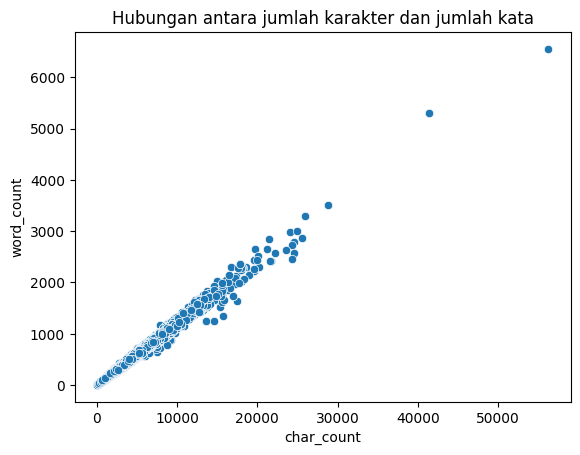

In [22]:
df_explore[['char_count', 'word_count']].corr()
sns.scatterplot(data=df_explore, x='char_count', y='word_count')
plt.title("Hubungan antara jumlah karakter dan jumlah kata")
plt.show()

# Cleaning

In [23]:
print(f"Jumlah data sebelum menghapus null dan duplikat: {len(df)}")

df = df.dropna()

df = df.drop_duplicates()

print(f"Jumlah data setelah menghapus null dan duplikat: {len(df)}")

Jumlah data sebelum menghapus null dan duplikat: 13389
Jumlah data setelah menghapus null dan duplikat: 12275


In [24]:
import re
import pandas as pd

col = "Text"

contractions = {
    "ain't": "is not", "aren't": "are not", "can't": "cannot", "couldn't": "could not",
    "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not",
    "hasn't": "has not", "haven't": "have not", "he's": "he is", "she's": "she is",
    "it's": "it is", "I'm": "I am", "isn't": "is not", "let's": "let us", "mightn't": "might not",
    "mustn't": "must not", "shan't": "shall not", "shouldn't": "should not", "that's": "that is",
    "there's": "there is", "they're": "they are", "wasn't": "was not", "we're": "we are",
    "weren't": "were not", "what's": "what is", "won't": "will not", "wouldn't": "would not",
    "you're": "you are", "you've": "you have"
}

def expand_contractions(text):
    pattern = re.compile(r'\b(' + '|'.join(contractions.keys()) + r')\b')
    return pattern.sub(lambda x: contractions[x.group()], text)

def clean_text(text):
    text = str(text).lower()                                # lowercase
    text = expand_contractions(text)                        # ekspansi kontraksi
    text = re.sub(r"http\S+|www\S+", "", text)              # hapus URL
    text = re.sub(r"[^a-z\s]", " ", text)                   # hapus non-alfabet
    text = re.sub(r"\s+", " ", text).strip()                # hapus spasi berlebih
    return text

df['clean_text'] = df[col].apply(clean_text)

df[['Text', 'clean_text']].head(5)

,Text,clean_text
0,education omba executive leadership university...,education omba executive leadership university...
1,howard gerrard accountant deyjobcom birmingham...,howard gerrard accountant deyjobcom birmingham...
2,kevin frank senior accountant inforesumekraftc...,kevin frank senior accountant inforesumekraftc...
3,place birth nationality olivia ogilvy accounta...,place birth nationality olivia ogilvy accounta...
4,stephen greet cpa senior accountant 9 year exp...,stephen greet cpa senior accountant year exper...


Jumlah data awal: 12275
Jumlah data setelah filtering: 12263
Data yang dibuang: 12


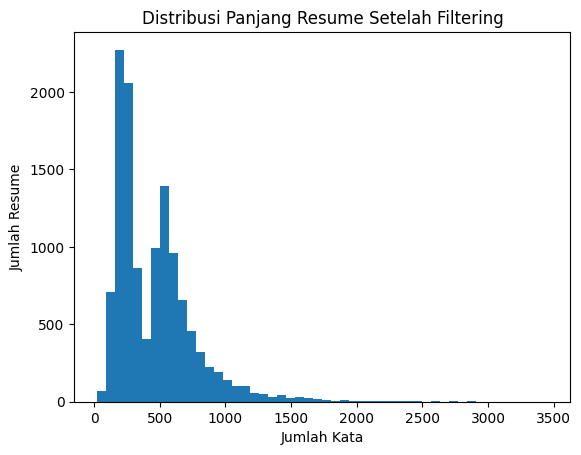

In [25]:
df['word_count'] = df['clean_text'].apply(lambda x: len(str(x).split()))

min_len = 20
max_len = 4000

df_filtered = df[(df['word_count'] >= min_len) & (df['word_count'] <= max_len)]

print(f"Jumlah data awal: {len(df)}")
print(f"Jumlah data setelah filtering: {len(df_filtered)}")
print(f"Data yang dibuang: {len(df) - len(df_filtered)}")

plt.hist(df_filtered['word_count'], bins=50)
plt.title("Distribusi Panjang Resume Setelah Filtering")
plt.xlabel("Jumlah Kata")
plt.ylabel("Jumlah Resume")
plt.show()

In [26]:
from sklearn.model_selection import train_test_split

text_col = "clean_text"
label_col = "Category"

train_df, test_df = train_test_split(
    df_filtered,
    test_size=0.2,
    stratify=df_filtered[label_col],
    random_state=42
)

print("Jumlah data total :", len(df_filtered))
print("Data train        :", len(train_df))
print("Data test         :", len(test_df))
print("Proporsi label train:")
print(train_df[label_col].value_counts(normalize=True).head())
print("Proporsi label test:")
print(test_df[label_col].value_counts(normalize=True).head())

Jumlah data total : 12263
Data train        : 9810
Data test         : 2453
Proporsi label train:
Category
Education                 0.031600
Electrical Engineering    0.029562
Sales                     0.028236
Consultant                0.028135
Digital Media             0.027829
Name: proportion, dtype: float64
Proporsi label test:
Category
Education                 0.031798
Electrical Engineering    0.029352
Consultant                0.028129
Sales                     0.028129
Digital Media             0.027721
Name: proportion, dtype: float64


In [ ]:
from sklearn.preprocessing import LabelEncoder
from datasets import Dataset
from transformers import DistilBertTokenizerFast

label_col = 'Category'

le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df[label_col])
test_df['label'] = le.transform(test_df[label_col])

num_labels = len(le.classes_)
print("Total kelas unik:", num_labels)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

X_train = train_df['clean_text']
y_train = train_df['label']

class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(le.classes_)),
    y=y_train
)

# clip weights agar tidak terlalu ekstrem
class_weights = np.clip(class_weights, 0.5, 3.0)  # max 3x, min 0.5x
print("Clipped class weights:", class_weights)

Clipped class weights: [0.84496124 1.01848007 1.27452254 0.90173729 0.93499809 1.15221987
 0.94272535 0.87409783 1.45311806 0.97495528 3.         0.85126692
 0.91622303 0.92739648 0.82659252 1.04173304 1.20073439 1.13502256
 1.15221987 0.83567595 0.97495528 1.09157672 0.73593398 0.78668805
 0.85766742 1.96672013 0.96669294 0.93884582 1.10212336 0.93499809
 0.88426176 0.84810236 0.92364184 0.8641649  1.15221987 0.92364184
 1.25351393 1.66525208 1.000612   0.95856947 0.82360843 0.88426176
 0.96669294]


In [33]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

example_text = train_df['clean_text'].iloc[0]
tokens = tokenizer(example_text, truncation=True, padding='max_length', max_length=512)
print("Tokenized sample keys:", tokens.keys())
print("Token IDs (first 20):", tokens['input_ids'][:20])

Tokenized sample keys: KeysView({'input_ids': [101, 10373, 5925, 18037, 2480, 9006, 3042, 3630, 2171, 2476, 16429, 20614, 3512, 2147, 3029, 3625, 2597, 4087, 2968, 4813, 9412, 7528, 4411, 3930, 7570, 27982, 5962, 2189, 5983, 12090, 2833, 4568, 4769, 2395, 2103, 2110, 3834, 26426, 9031, 2015, 5065, 2974, 6228, 3330, 9572, 16215, 9572, 6568, 2063, 16215, 9572, 6568, 2063, 3167, 2951, 11397, 2171, 2731, 15007, 20913, 4813, 2621, 2731, 2622, 3684, 2686, 3514, 6402, 2121, 4007, 8285, 28353, 12235, 12235, 5083, 4937, 2401, 2019, 6508, 2015, 3716, 25196, 5906, 1055, 3058, 4182, 5907, 10662, 26293, 2982, 13832, 5428, 18697, 8163, 2465, 4387, 2465, 16215, 16215, 2599, 2136, 7314, 3049, 6875, 6456, 2047, 2141, 10834, 2621, 3018, 2644, 12235, 11216, 2267, 1050, 2094, 3396, 6228, 3330, 17037, 2971, 17768, 5498, 4194, 27937, 9834, 2120, 4746, 4087, 9412, 4083, 3919, 3942, 6090, 3211, 19526, 4194, 28355, 2401, 19461, 2223, 2378, 18014, 8312, 8476, 3808, 2250, 8641, 3765, 102, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
def tokenize_function(batch):
    return tokenizer(
        batch['clean_text'],
        truncation=True,
        padding='max_length',
        max_length=512
    )

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_encoded = train_dataset.map(tokenize_function, batched=True)
test_encoded = test_dataset.map(tokenize_function, batched=True)

train_encoded.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label']
)
test_encoded.set_format(
    type='torch',
    columns=['input_ids', 'attention_mask', 'label']
)

print("Train dataset:", train_encoded)
print("Test dataset:", test_encoded)

Map: 100%|██████████| 2453/2453 [00:01<00:00, 2043.93 examples/s]

Train dataset: Dataset({
    features: ['Category', 'Text', 'clean_text', 'word_count', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 9810
})
Test dataset: Dataset({
    features: ['Category', 'Text', 'clean_text', 'word_count', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2453
})


# Inisialisasi DistilBERT

In [31]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_encoded, batch_size=16, shuffle=True)
test_loader = DataLoader(test_encoded, batch_size=16)

In [ ]:
from transformers import DistilBertForSequenceClassification, get_scheduler
from torch.optim import AdamW
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

# 1 menginisialisasi model DistilBERT sebagai sequence classification model.
num_labels = len(le.classes_)
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
).to(device)

# gunakan class weight
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

# optimizer & scheduler
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 15
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

print(f"Total training steps: {num_training_steps}")

Device in use: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total training steps: 9210


In [37]:
from sklearn.metrics import accuracy_score

patience = 3
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        loss = loss_fn(outputs.logits, batch["label"])
        preds = torch.argmax(outputs.logits, dim=1)

        # Accuracy
        total_correct += (preds == batch["label"]).sum().item()
        total_samples += batch["label"].size(0)

        # Backpropagation
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples

    # Validation Loop
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}

            outputs = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )
            # Gunakan loss_fn untuk validation juga
            loss = loss_fn(outputs.logits, batch["label"])
            val_loss += loss.item()

            val_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            val_labels.extend(batch["label"].cpu().numpy())

    avg_val_loss = val_loss / len(test_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("model saved")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping setelah {epoch+1} epochs")
            break

Epoch 1/15 | Train Loss: 2.3064 | Val Loss: 0.9214 | Train Acc: 0.5154 | Val Acc: 0.8382
model saved
Epoch 2/15 | Train Loss: 0.6815 | Val Loss: 0.5591 | Train Acc: 0.8738 | Val Acc: 0.8801
model saved
Epoch 3/15 | Train Loss: 0.4151 | Val Loss: 0.4955 | Train Acc: 0.9130 | Val Acc: 0.8920
model saved
Epoch 4/15 | Train Loss: 0.3130 | Val Loss: 0.4961 | Train Acc: 0.9308 | Val Acc: 0.8903
Epoch 5/15 | Train Loss: 0.2459 | Val Loss: 0.4851 | Train Acc: 0.9441 | Val Acc: 0.8981
model saved
Epoch 6/15 | Train Loss: 0.2059 | Val Loss: 0.4795 | Train Acc: 0.9521 | Val Acc: 0.8948
model saved
Epoch 7/15 | Train Loss: 0.1700 | Val Loss: 0.4833 | Train Acc: 0.9598 | Val Acc: 0.8924
Epoch 8/15 | Train Loss: 0.1390 | Val Loss: 0.4799 | Train Acc: 0.9670 | Val Acc: 0.8969
Epoch 9/15 | Train Loss: 0.1224 | Val Loss: 0.4787 | Train Acc: 0.9725 | Val Acc: 0.8989
model saved
Epoch 10/15 | Train Loss: 0.1009 | Val Loss: 0.5042 | Train Acc: 0.9760 | Val Acc: 0.8952
Epoch 11/15 | Train Loss: 0.0879 | Va

Save Model

In [ ]:
# torch.save(model.state_dict(), "best_model.pt")
# print("save model best_model.pt")

## Evaluate

pastikan data 'test_loader' sudah di run

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\FAUZAN\AppData\Local\Temp\ipykernel_19984\3341588920.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless t

Model loaded successfully.
                           precision    recall  f1-score   support

               Accountant     0.9565    0.9851    0.9706        67
                 Advocate     0.9821    0.9821    0.9821        56
              Agriculture     0.8837    0.8636    0.8736        44
                  Apparel     0.8852    0.8571    0.8710        63
             Architecture     0.8519    0.7541    0.8000        61
                     Arts     0.8846    0.9388    0.9109        49
               Automobile     0.8667    0.8525    0.8595        61
                 Aviation     0.9841    0.9538    0.9688        65
                      BPO     0.7949    0.7949    0.7949        39
                  Banking     0.9821    0.9483    0.9649        58
               Blockchain     0.8000    1.0000    0.8889         8
Building and Construction     0.8732    0.9254    0.8986        67
         Business Analyst     0.9104    0.9839    0.9457        62
           Civil Engineer     0.98

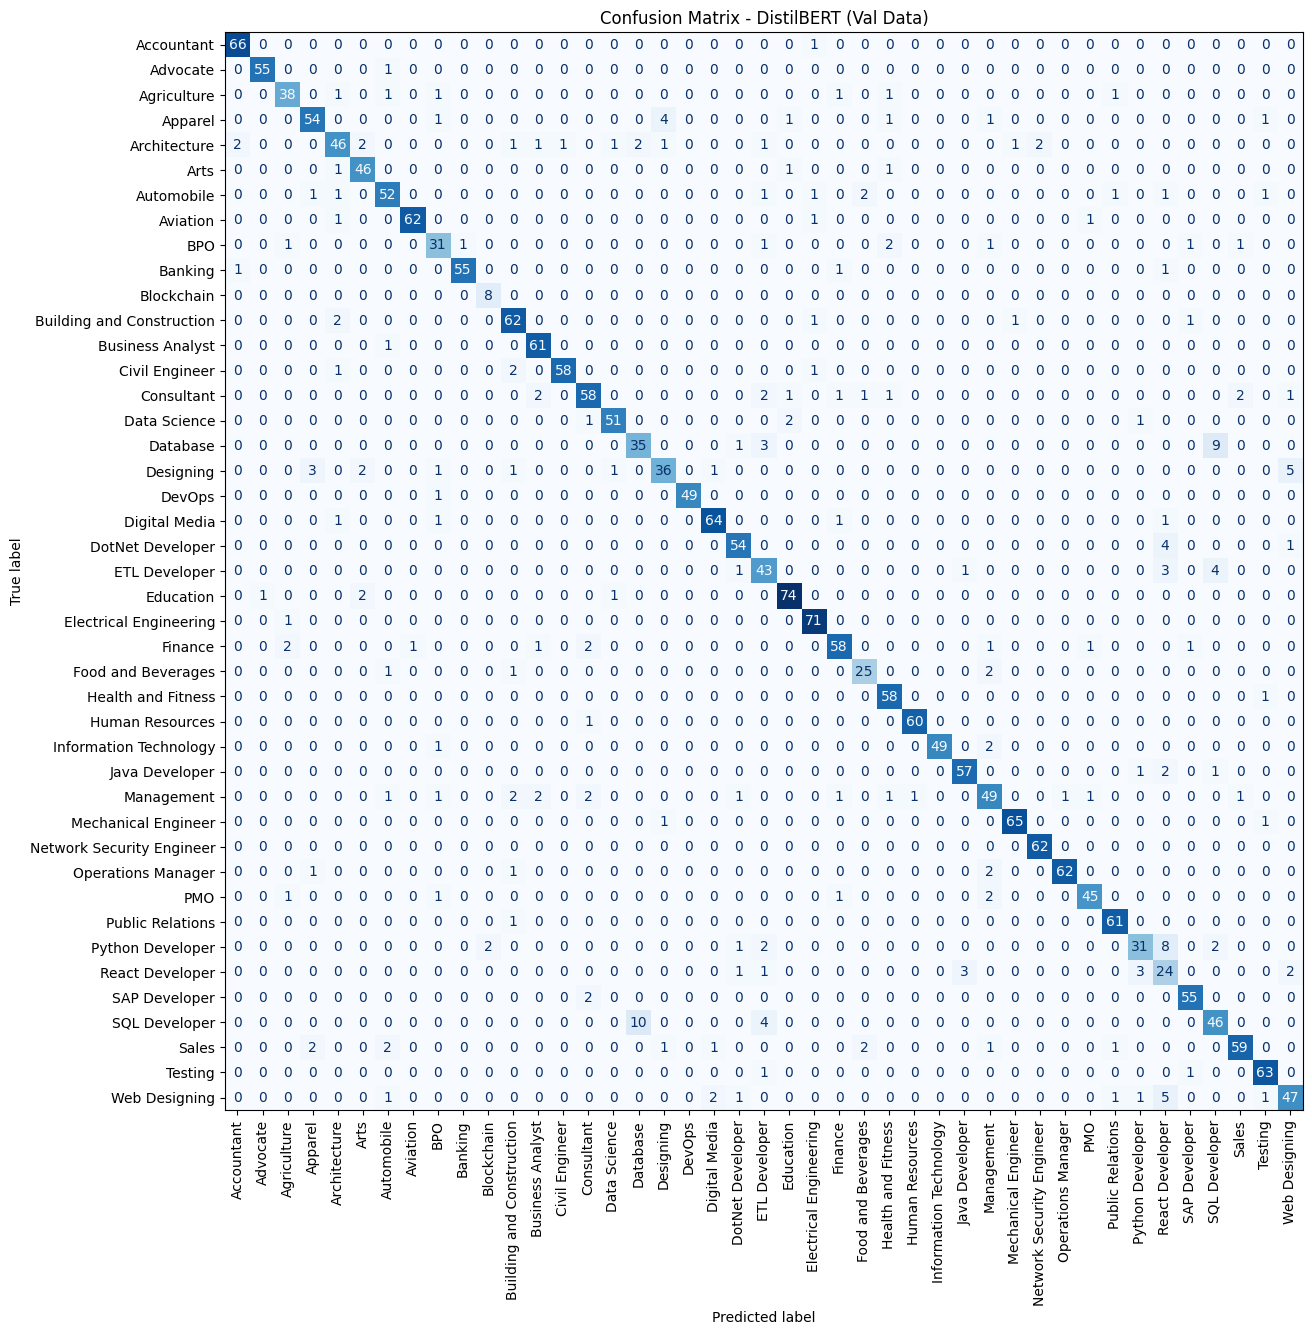

In [ ]:
import torch
import pickle
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

tokenizer = DistilBertTokenizerFast.from_pretrained("./tokenizer")

num_labels = len(le.classes_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
).to(device)

model.load_state_dict(torch.load("best_model.pt", map_location=device))
model.eval()

print("Model loaded successfully.")

from sklearn.metrics import classification_report, f1_score, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["label"].cpu().numpy())

# === Laporan Klasifikasi ===
print(classification_report(all_labels, all_preds, target_names=le.classes_, digits=4))

# === Confusion Matrix ===
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix - DistilBERT (Val Data)")
plt.show()


Dari visualisasi confusion matrix di atas, dapat dilihat bahwa kesalahan klasifikasi paling sering terjadi pada kategori SQL Developer dan Database. Hal ini kemungkinan disebabkan oleh kemiripan antara kedua jenis pekerjaan tersebut.

### Simpan encoder, tokenizer, dan model untuk digunakan dalam pipeline dan streamlit supaya konsisten

In [ ]:
import pickle
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import pandas as pd

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("Label encoder saved to 'label_encoder.pkl'")

tokenizer.save_pretrained('./tokenizer')
print("Tokenizer saved to './tokenizer'")

model.save_pretrained('./model')
print("Model saved to './model'")

Label encoder saved to 'label_encoder.pkl'
Tokenizer saved to './tokenizer'
Model saved to './model'


# TF-IDF + Random Forest

In [33]:
df.head()

,Category,Text,clean_text,word_count
0,Accountant,education omba executive leadership university...,education omba executive leadership university...,144
1,Accountant,howard gerrard accountant deyjobcom birmingham...,howard gerrard accountant deyjobcom birmingham...,221
2,Accountant,kevin frank senior accountant inforesumekraftc...,kevin frank senior accountant inforesumekraftc...,253
3,Accountant,place birth nationality olivia ogilvy accounta...,place birth nationality olivia ogilvy accounta...,275
4,Accountant,stephen greet cpa senior accountant 9 year exp...,stephen greet cpa senior accountant year exper...,194


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pickle

with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

df["label"] = le.transform(df["Category"])

X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"], test_size=0.2, stratify=df["label"], random_state=42
)

In [30]:
print(X_train.shape)
print(X_test.shape)

(9820,)
(2455,)


In [ ]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    sublinear_tf=True
)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(le.classes_)),
    y=y_train
)
class_weights = np.clip(class_weights, 0.5, 3.0)
weight_dict = {i: w for i, w in enumerate(class_weights)}

print("Clipped class weights:", class_weights)

Clipped class weights: [0.84582257 1.01498708 1.25479172 0.90265649 0.9359512  1.14759846
 0.94368633 0.87164921 1.44539299 0.97594912 3.         0.85213468
 0.917157   0.92834184 0.82743512 1.04279495 1.20195838 1.13617957
 1.15339441 0.83652781 0.97594912 1.09268944 0.73431541 0.78748998
 0.8585417  1.96872494 0.96767836 0.93980285 1.10324683 0.9359512
 0.88516315 0.84582257 0.92458337 0.86178148 1.15339441 0.92458337
 1.25479172 1.66694958 1.00163199 0.95954661 0.82444799 0.88516315
 0.96767836]


### n_est 100

In [49]:
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight=weight_dict,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_tfidf, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [50]:
y_pred = rf.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)

print(f"\nWeighted TF-IDF + RandomForest Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))


Weighted TF-IDF + RandomForest Accuracy: 0.7825

                           precision    recall  f1-score   support

               Accountant      0.684     0.970     0.802        67
                 Advocate      0.765     0.929     0.839        56
              Agriculture      0.923     0.800     0.857        45
                  Apparel      0.750     0.857     0.800        63
             Architecture      0.929     0.639     0.757        61
                     Arts      0.744     0.592     0.659        49
               Automobile      0.818     0.738     0.776        61
                 Aviation      0.861     0.954     0.905        65
                      BPO      0.897     0.667     0.765        39
                  Banking      0.871     0.931     0.900        58
               Blockchain      0.727     0.889     0.800         9
Building and Construction      0.720     0.806     0.761        67
         Business Analyst      0.769     0.806     0.787        62
           

### n_est = 300

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight=weight_dict,
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train_tfidf, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_pred = rf.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)

print(f"\nWeighted TF-IDF + RandomForest Accuracy: {acc:.4f}\n")
print(classification_report(y_test, y_pred, target_names=le.classes_, digits=3))


Weighted TF-IDF + RandomForest Accuracy: 0.7849

                           precision    recall  f1-score   support

               Accountant      0.703     0.955     0.810        67
                 Advocate      0.746     0.946     0.835        56
              Agriculture      0.919     0.756     0.829        45
                  Apparel      0.786     0.873     0.827        63
             Architecture      0.909     0.656     0.762        61
                     Arts      0.811     0.612     0.698        49
               Automobile      0.833     0.738     0.783        61
                 Aviation      0.861     0.954     0.905        65
                      BPO      0.929     0.667     0.776        39
                  Banking      0.871     0.931     0.900        58
               Blockchain      0.727     0.889     0.800         9
Building and Construction      0.746     0.791     0.768        67
         Business Analyst      0.820     0.806     0.813        62
           

In [ ]:
import os
import pickle

os.makedirs("random_forest_file", exist_ok=True)

with open("random_forest_file/rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open("random_forest_file/tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

### Confussion Matrix TF-IDF + RF

In [ ]:
with open("random_forest_file/rf_model.pkl", "rb") as f:
    rf = pickle.load(f)

with open("random_forest_file/tfidf_vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

In [ ]:
from sklearn.preprocessing import LabelEncoder

with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

X_test_tfidf = vectorizer.transform(test_df["clean_text"])
y_test = le.transform(test_df["Category"])

y_pred = rf.predict(X_test_tfidf)

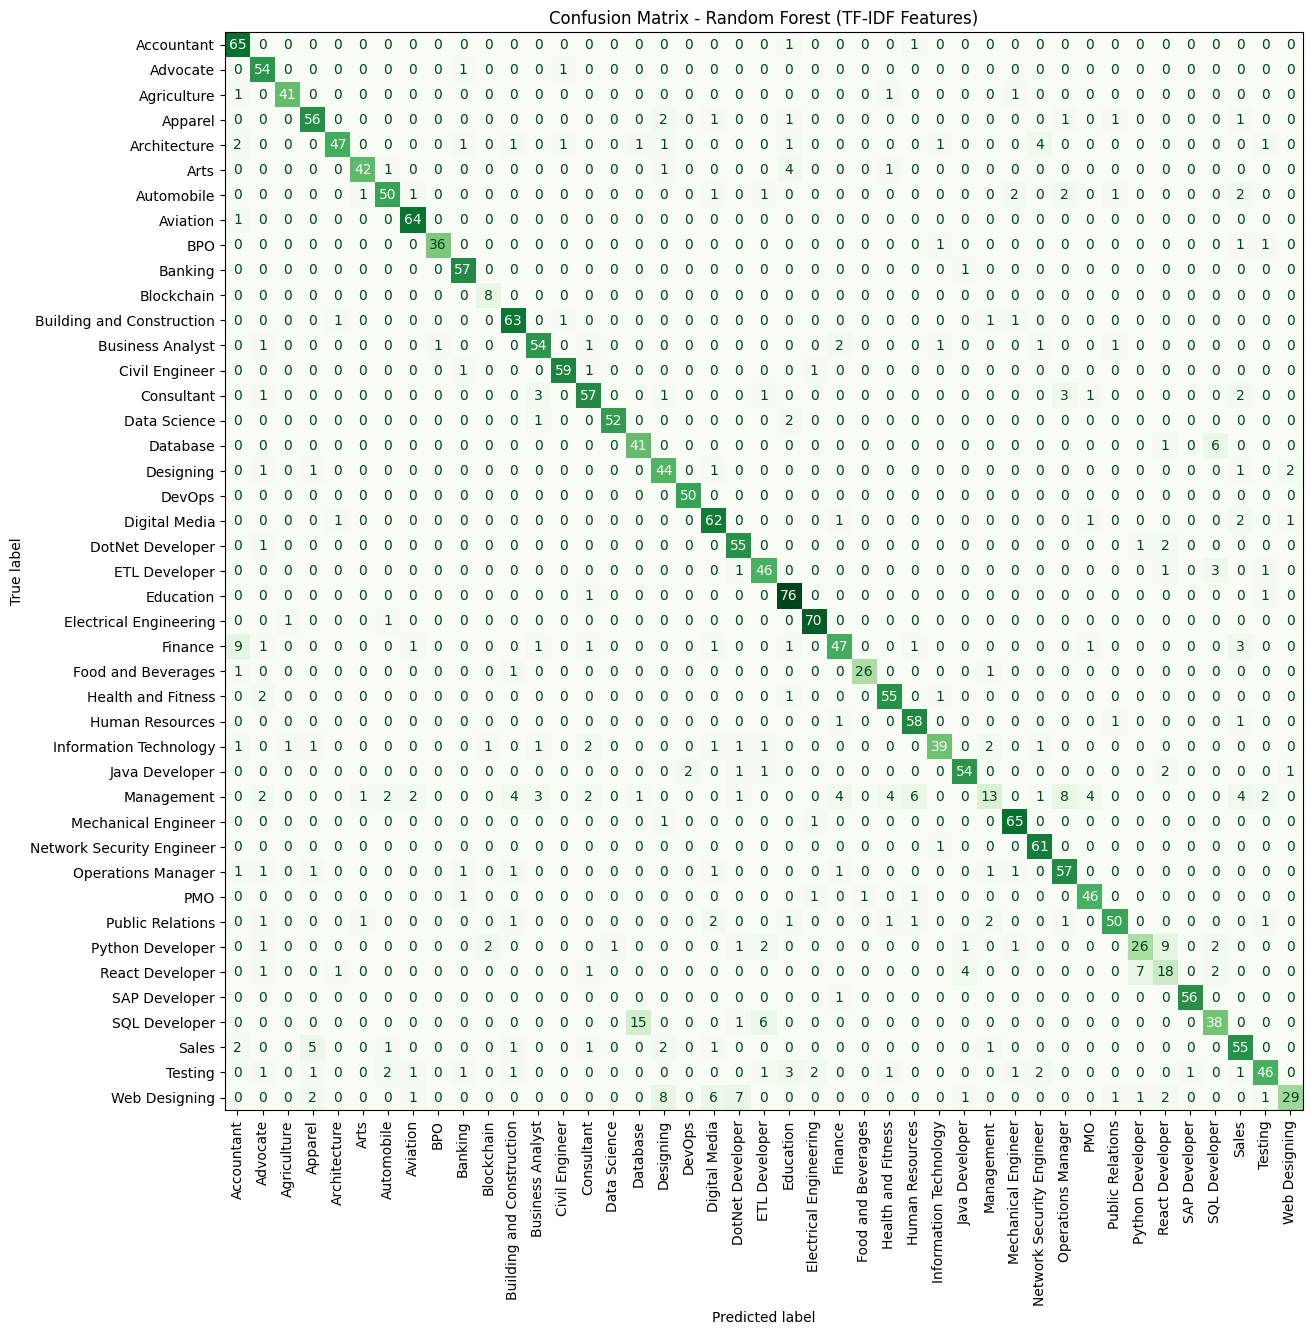

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(14, 14))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(ax=ax, xticks_rotation=90, cmap="Greens", colorbar=False)
plt.title("Confusion Matrix - Random Forest (TF-IDF Features)")
plt.show()

# Analisis hasil Distilbert dan RF

Berdasarkan hasil confusion matrix dan classification report, terlihat bahwa DistilBERT masih melakukan kesalahan klasifikasi antara kategori Database dan SQL Developer, dengan 9 data berlabel Database diprediksi sebagai SQL Developer, serta 10 data berlabel SQL Developer diprediksi sebagai Database.
Sementara itu, pada model TF-IDF + Random Forest, pola kesalahan serupa juga terjadi, namun dengan distribusi berbeda — terdapat 6 data Database yang diprediksi sebagai SQL Developer, dan 15 data SQL Developer yang diprediksi sebagai Database.

Hal ini menunjukkan bahwa kedua model mengalami kesulitan dalam membedakan kategori yang memiliki kemiripan konteks deskriptif pekerjaan. Namun, DistilBERT memperlihatkan distribusi kesalahan yang lebih seimbang, yang menandakan kemampuannya dalam memahami makna kontekstual antar kalimat.

Selain itu, hasil classification report juga memperlihatkan bahwa TF-IDF + Random Forest gagal menangkap konteks pada kategori tertentu seperti Web Designing, yang hanya memperoleh nilai recall 0.492 dan f1-score 0.598. Sebaliknya, DistilBERT berhasil mencapai recall 0.7966 dan f1-score 0.8174 pada kategori yang sama. Perbedaan ini memperkuat bukti bahwa DistilBERT lebih efektif dalam memahami konteks semantik yang kompleks, di mana istilah-istilah desain dan pengembangan web sering tumpang tindih secara leksikal tetapi berbeda makna secara konseptual.

Secara keseluruhan, DistilBERT menunjukkan akurasi 0.899 dan rata-rata F1 0.891, melampaui TF-IDF + Random Forest yang hanya mencapai akurasi 0.785 dan F1 0.778. Performa yang lebih tinggi ini sejalan dengan temuan González-Carvajal dan Garrido-Merchán (2020) dalam studi `“Comparing BERT against traditional machine learning text classification”`, yang menunjukkan bahwa model berbasis transformer seperti BERT yang merupakan arsitektur induk DistilBERT secara konsisten mengungguli model tradisional berbasis TF-IDF karena kemampuannya menangkap hubungan semantik antar kata dalam konteks kalimat, bukan sekadar menghitung frekuensi kemunculan kata.

sumber: González-Carvajal, S., & Garrido-Merchán, E. C. (2020). Comparing BERT against traditional machine learning text classification. arXiv preprint arXiv:2005.13012. https://www.researchgate.net/publication/341699413